# Dynamic Watering Point Localization for Soil Channeling Prevention Using Computer Vision
Teng Tian

In [537]:
%matplotlib inline
#import library
from plantcv import plantcv as pcv
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
#import time library to measure the execution time
import time
import math

In [538]:
# automaticly show image after every process
pcv.params.debug="plot"

The images used in this work were captured by the on-board camera of Farmbot and were taken in the University Greenhouse.

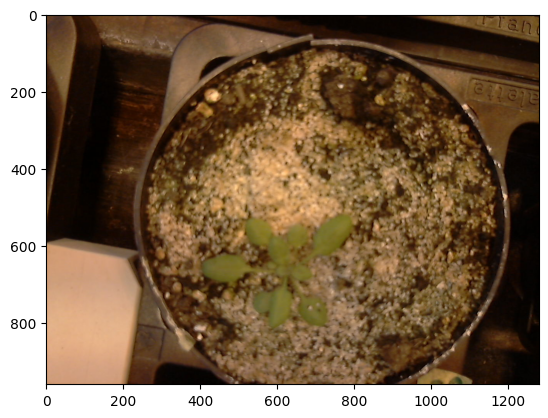

In [539]:
# read an image
img,path,filename=pcv.readimage(filename="../data/CAM_greenhouse/fotos_ideal_condition/Farmbot_GH_ideal_1.jpg", mode="rgb")

## Step 1: finde the location of the plants
Analyzing the image in different color spaces provides a clear understanding of the image properties.

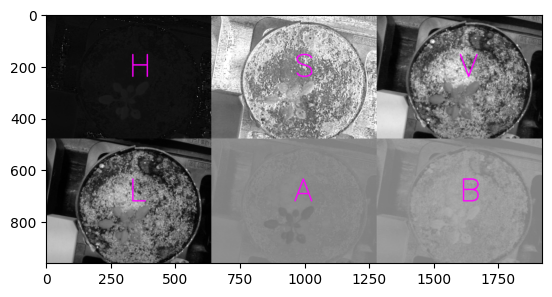

In [540]:
pcv.params.text_size = 8
pcv.params.text_thickness = 10
colorspaces=pcv.visualize.colorspaces(rgb_img=img, original_img=False)

Using channel A will provide the most significant color difference between plants and surrounding objects, as well as the soil beneath them.

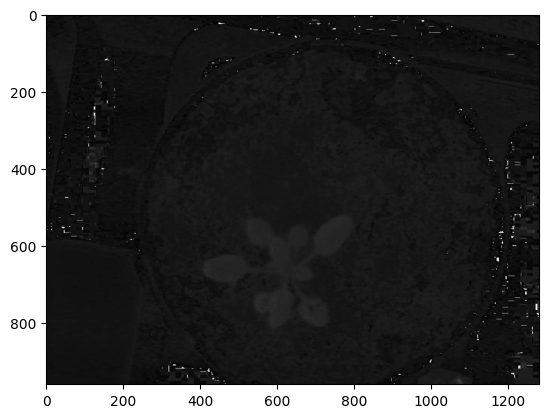

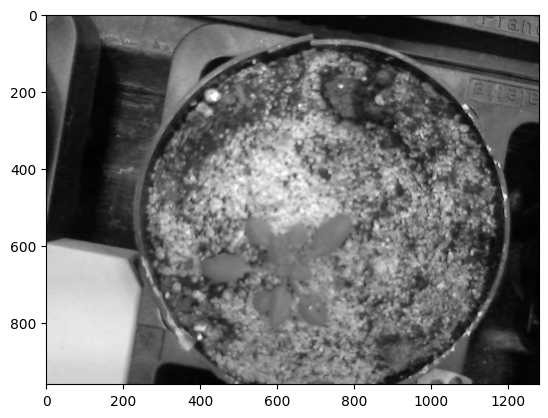

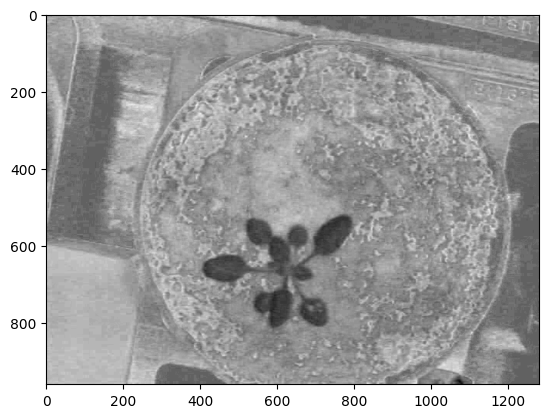

In [541]:
# have a close look at the A-channel
img_H=pcv.rgb2gray_hsv(rgb_img=img, channel="H")
img_V=pcv.rgb2gray_hsv(rgb_img=img, channel="V")
img_A=pcv.rgb2gray_lab(rgb_img=img, channel="A")

The plants appear to have a darker color. Let's check the histogram to confirm this.

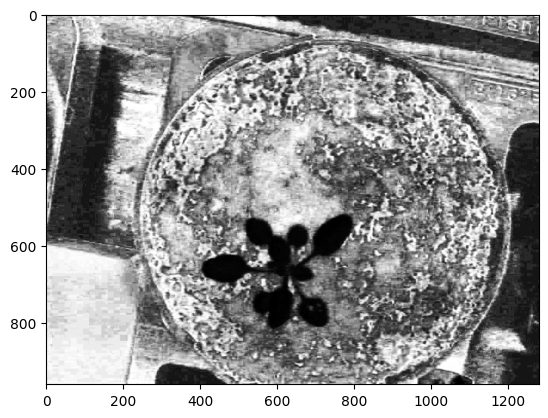

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

In [542]:
img_A_hist_EQU=pcv.hist_equalization(img_A)

pcv.visualize.histogram(img=img_H)
pcv.visualize.histogram(img=img_V)
pcv.visualize.histogram(img=img_A)
pcv.visualize.histogram(img=img_A_hist_EQU)

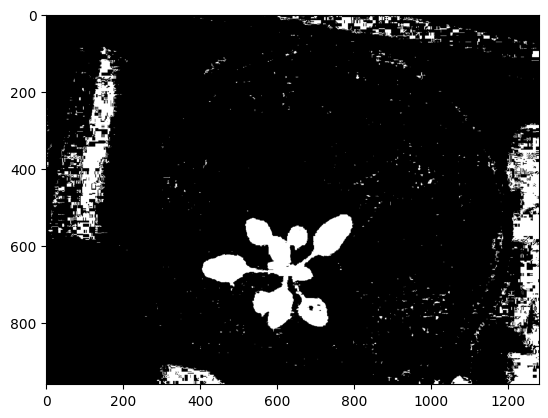

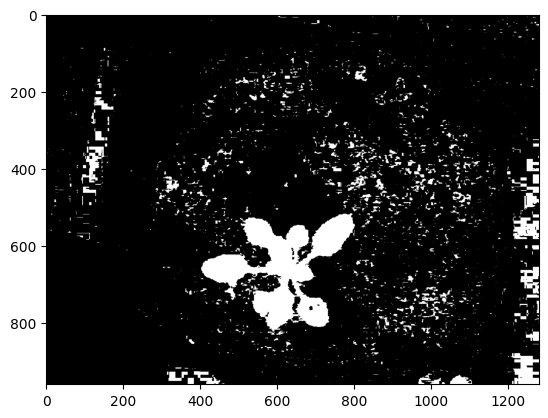

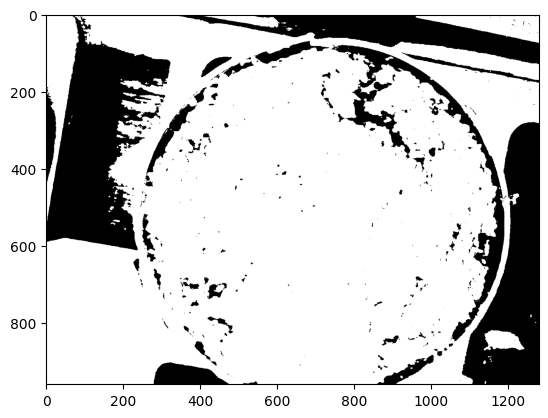

In [543]:
# in this way we habe now a binary mask
pcv.params.debug="none"

#img_A_thresh = pcv.threshold.binary(gray_img=img_A, threshold = 135, object_type = 'light')
img_A_thresh, __ = pcv.threshold.custom_range(img=img_A_hist_EQU, lower_thresh=[0], upper_thresh=[25], channel='gray')
img_H_thresh, __ = pcv.threshold.custom_range(img=img_H, lower_thresh=[20], upper_thresh=[90], channel='gray')
#img_A_thresh, __ = pcv.threshold.custom_range(img=img_A, lower_thresh=[100], upper_thresh=[125], channel='gray')
img_V_thresh_up = pcv.threshold.binary(gray_img=img_V, threshold = 250, object_type='dark')
img_V_thresh_down = pcv.threshold.binary(gray_img=img_V, threshold = 50, object_type='light')
img_V_thresh = cv.bitwise_and(img_V_thresh_up,img_V_thresh_down)

pcv.plot_image(img_A_thresh)
pcv.plot_image(img_H_thresh)
pcv.plot_image(img_V_thresh)

pcv.params.debug="plot"

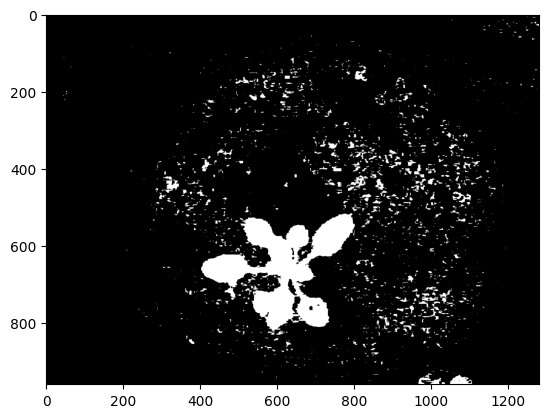

In [544]:
img_thresh = cv.bitwise_or(img_A_thresh,img_H_thresh)
img_thresh = cv.bitwise_and(img_thresh,img_V_thresh)
pcv.plot_image(img_thresh)

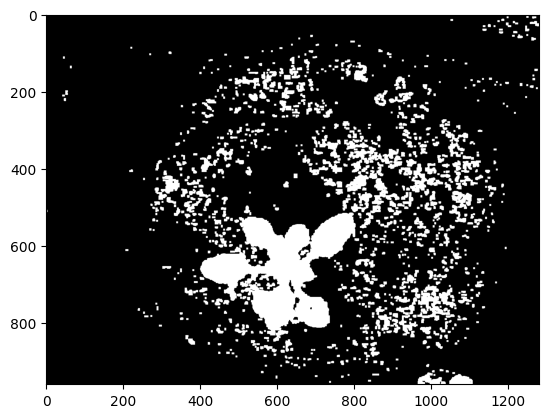

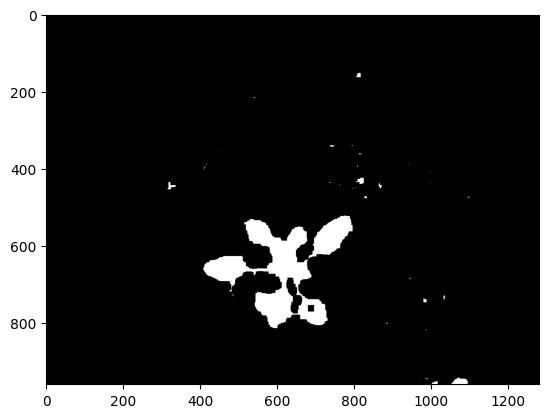

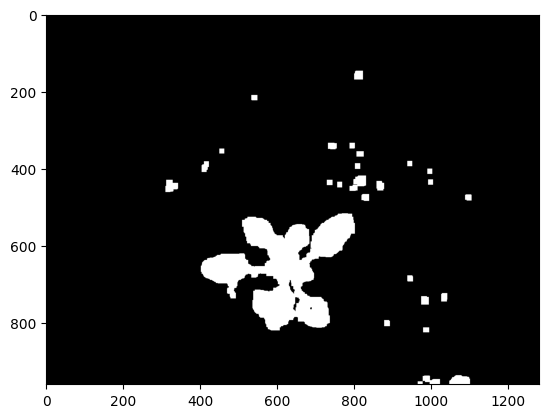

In [545]:
# using closing methode to have a better image for region finding methode
mask_dilated = pcv.dilate(gray_img = img_thresh, ksize = 3, i = 2)
mask_erode = pcv.erode(gray_img = mask_dilated, ksize = 5, i =3)
mask_dilated = pcv.dilate(gray_img = mask_erode, ksize = 5, i = 3)
mask = mask_dilated

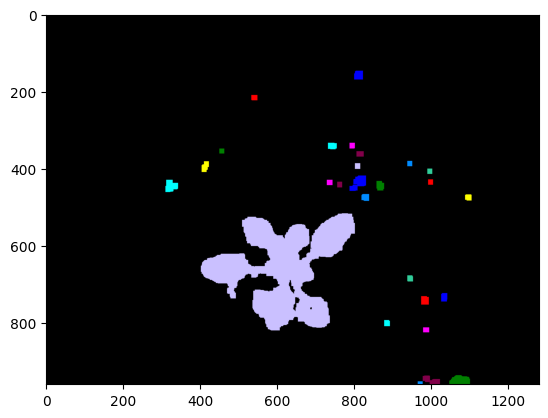

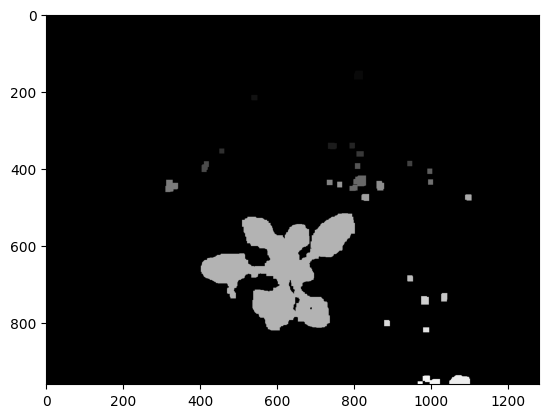

total 27 region(s) found!


In [546]:
# labeled the regions on the mask image
labeled_mask, num_mask = pcv.create_labels(mask=mask)
pcv.plot_image(labeled_mask)
print('total', num_mask, 'region(s) found!')

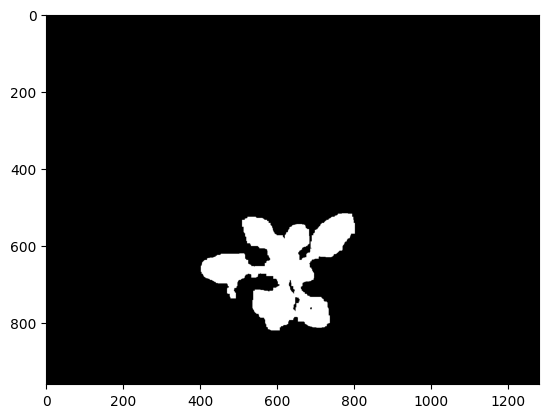

In [547]:
# just keep the biggst region on the mask
count_prev = 0
count = 0
for region_id in range(1,num_mask+1,1):
    mask_region_cnt = cv.inRange(labeled_mask,region_id,region_id)
    count = cv.countNonZero(mask_region_cnt)
    contours_draw, hierarchy = cv.findContours(mask_region_cnt,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
    arcLength_contour = cv.arcLength(contours_draw[0], True)
    if arcLength_contour > 5000: # This depends on the flower pot
        next
    elif count>count_prev:
        mask_cop = mask_region_cnt
        count_prev = count
    else:
        next
pcv.plot_image(mask_cop)

616 660


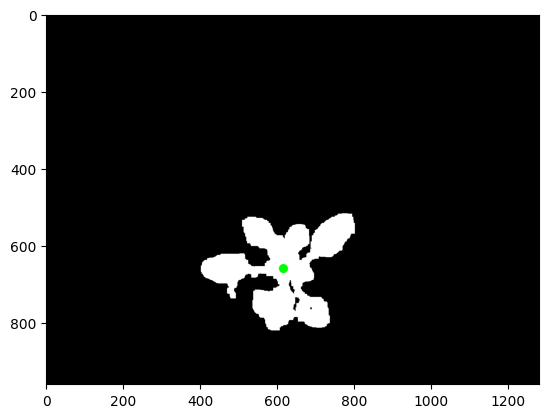

In [548]:
# calculation the center of mass of the region
# this will locate the plant
contours, hierarchy = cv.findContours(mask_cop,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
M = cv.moments(cnt)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
print(cx,cy)
mask_RGB=cv.cvtColor(mask_cop,cv.COLOR_GRAY2BGR)
cv.circle(mask_RGB,(cx,cy),2,(0,255,0),20)
pcv.plot_image(mask_RGB)

Now we have a fairly accurate mask that shows where the plants are located.

## Step 2: Determine the inner area of the flower pot
The hough-circle method is being used to detect flower pots in the image. As a prerequisite, it is necessary to determine the minimum distance between two pots and the pot radius in pixels. This refers to these parameters:
- mindDist
- minRadius
- maxRadius

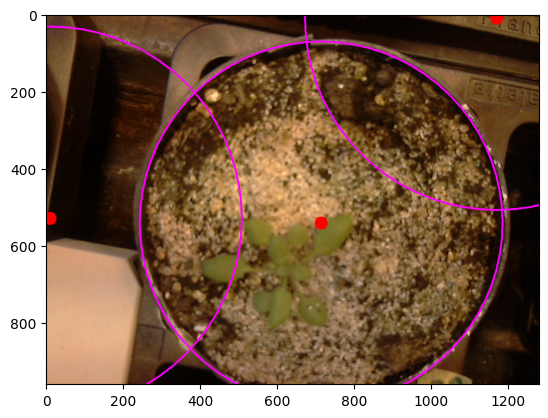

Execution time: 0.63 seconds


In [552]:
# using hough-circle to dectect flower pot(s) in the image
# as a precondition, we need to know the smallest distance between two pots and the radius of the pot in pixel
'''
cv.HoughCircles (image, circles, method, dp, minDist, param1 = 100, param2 = 100, minRadius = 0, maxRadius = 0)

Parameters
image	8-bit, single-channel, grayscale input image.
circles	output vector of found circles(cv.CV_32FC3 type). Each vector is encoded as a 3-element floating-point vector (x,y,radius) .
method	detection method(see cv.HoughModes). Currently, the only implemented method is HOUGH_GRADIENT
dp	inverse ratio of the accumulator resolution to the image resolution. For example, if dp = 1 , the accumulator has the same resolution as the input image. If dp = 2 , the accumulator has half as big width and height.
minDist	minimum distance between the centers of the detected circles. If the parameter is too small, multiple neighbor circles may be falsely detected in addition to a true one. If it is too large, some circles may be missed.
param1	first method-specific parameter. In case of HOUGH_GRADIENT , it is the higher threshold of the two passed to the Canny edge detector (the lower one is twice smaller).
param2	second method-specific parameter. In case of HOUGH_GRADIENT , it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first.
minRadius	minimum circle radius.
maxRadius	maximum circle radius.
'''
img_HoughCircles = img.copy()
start_time = time.time()
circles_list = []
img_GRAY=cv.cvtColor(img,cv.COLOR_BGR2GRAY)
img_mB = cv.medianBlur(img_GRAY,5)
circles= cv.HoughCircles(image=img_mB,method=cv.HOUGH_GRADIENT,dp=4,minDist=700,param1=60,param2=40,minRadius=450,maxRadius=500)
circles = np.uint16(np.around(circles))
circles_list.append(circles)
for i in circles[0,:]:
    # draw the outer circle
    cv.circle(img_HoughCircles,(i[0],i[1]),i[2],(255,0,255),4)
    # draw the center of the circle
    cv.circle(img_HoughCircles,(i[0],i[1]),2,(0,0,255),30)
pcv.plot_image(img_HoughCircles)
end_time = time.time()
print('Execution time:', round(end_time - start_time, 2), 'seconds')

The Hough Circle algorithm may find more than one circle in the image. The circle we are searching for is among them, and this is the most crucial aspect. The next step is to select the filter to exclude incorrect circles.

Distance to  1 . circle = 153
Distance to  2 . circle = 619
Distance to  3 . circle = 854
The 1 circle is the wanted circle
Position of the flowerpot is x= 714 y= 542 radius= 471


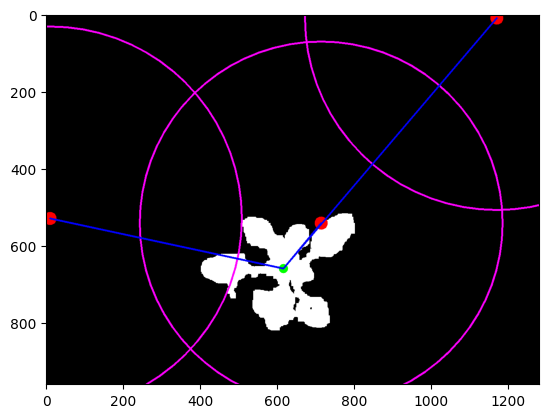

In [553]:
# we take only the circle, whose center is closest to center of the plant 
cnt = 1
index = 0
distance_prev = 0
for i in circles[0,:]:
    # draw the outer circle
    cv.circle(mask_RGB,(i[0],i[1]),i[2],(255,0,255),4)
    # draw the center of the circle
    cv.circle(mask_RGB,(i[0],i[1]),2,(0,0,255),30)
    # draw a line from the center of the circle to center of mass
    cv.line(mask_RGB,(i[0],i[1]), (cx,cy),(255,0,0),4)
    distance = (int)(math.sqrt((cx-i[0])**2+(cy-i[1])**2))
    if distance<distance_prev:
        index = cnt - 1
    print('Distance to ',cnt,'. circle =', distance)
    cnt=cnt+1
print('The',index+1, 'circle is the wanted circle')
pot_x = circles[0][index][0]
pot_y = circles[0][index][1]
pot_radius = circles[0][index][2]
print('Position of the flowerpot is', 'x=', pot_x,'y=',pot_y,'radius=',pot_radius)
pcv.plot_image(mask_RGB)

# Step 3: Setting watering points
Now we know the exact location of the plants and the pot. The area in the pot can be divided for dynamic watering.
Yesterday, I utilized a straightforward method. An edge area was set to prevent water from flowing out of the pot and to prevent soil channels from forming at the edge of the pot. The pot is divided into 12 parts and checked for plant leaves. If there are no leaves, a watering point is set in the area.

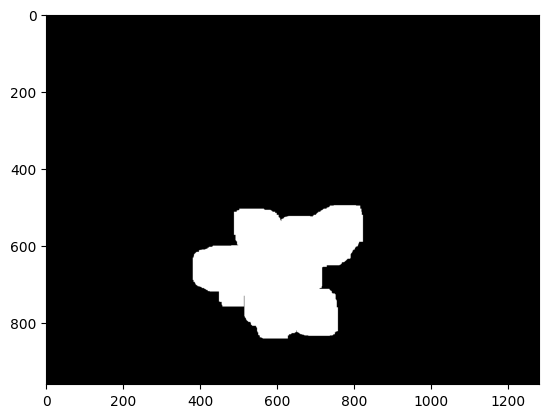

In [555]:
# let us define the watering point.
# It cannot be at the edge area, and either on top of the plant
edge_area = 150 # 100 Pixel to the edge will not be watered
# create watering point
angel = 30 # must be 15, 30, 45, 60, 90
# the previous mask will be enlarged, so that there will be a safty zone, that we will not water the leaves
mask_with_saftyzone = pcv.dilate(gray_img = mask_cop, ksize = 15, i = 3)
watering_point_list = []
for i in range(0, (int)(360/angel)):
    x_watering_point = (int)(math.cos(i*angel/180*math.pi)*(pot_radius - edge_area)+pot_x)
    y_watering_point = (int)(math.sin(i*angel/180*math.pi)*(pot_radius - edge_area)+pot_y)
    if mask_with_saftyzone[y_watering_point, x_watering_point] != 255:
        watering_point_list.append((x_watering_point, y_watering_point))
    #watering_point_list.append((x_watering_point, y_watering_point))

prossible watering point: (1035, 542)
prossible watering point: (991, 702)
prossible watering point: (874, 819)
prossible watering point: (714, 863)
prossible watering point: (393, 542)
prossible watering point: (436, 381)
prossible watering point: (553, 264)
prossible watering point: (713, 221)
prossible watering point: (874, 264)
prossible watering point: (991, 381)


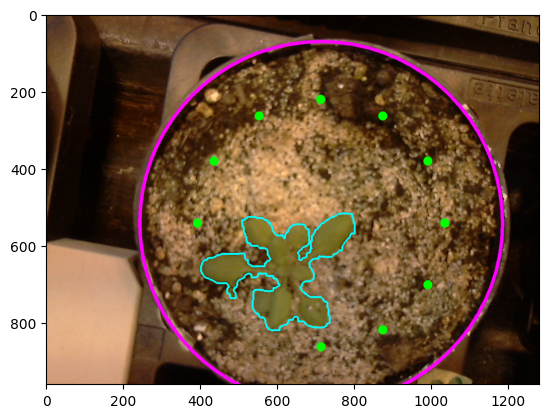

In [556]:
# lets draw everything on image
img_out = img.copy()
cv.circle(img_out,(pot_x,pot_y),pot_radius,(255,0,255),8)
for i in watering_point_list:
    cv.circle(img_out,i,2,(0,255,0),20)
    print('prossible watering point:',i)
cv.drawContours(img_out, contours, 0, (255,255,0), 3)
pcv.plot_image(img_out)

## Testing and Evaluation
### Testing with test images
I have prepared 10 images taken by the FarmBot camera for testing. Each image contains only one plant and one pot. Some images were captured on the edge of the farming platform. In the image, metal parts of the platform are visible. Some items are photographed under warm lighting, which affects their colors.

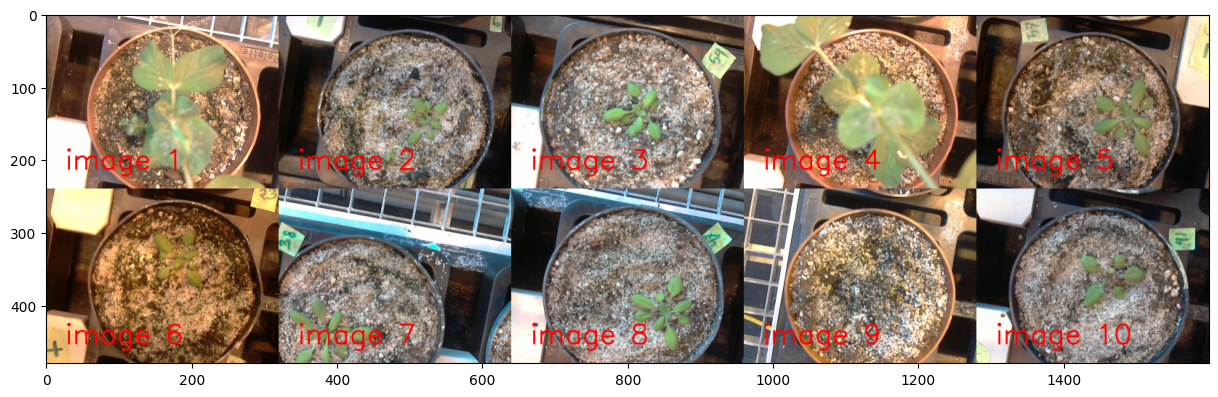

In [557]:
#img,path,filename=pcv.readimage(filename="../data/CAM_greenhouse/fotos_ideal_condition/Farmbot_GH_ideal_1.jpg", mode="rgb")
test_image_names = ["image 1", "image 2", "image 3", "image 4", "image 5", "image 6", "image 7", "image 8", "image 9", "image 10"]
test_images = []
labeled_test_images = []
test_image_file_names = ["Farmbot_GH_ideal_2.jpg",
                         "Farmbot_GH_ideal_3.jpg",
                         "Farmbot_GH_ideal_4.jpg",
                         "Farmbot_GH_ideal_5.jpg",
                         "Farmbot_GH_ideal_6.jpg",
                         "Farmbot_GH_ideal_7.jpg",
                         "Farmbot_GH_ideal_8.jpg",
                         "Farmbot_GH_ideal_9.jpg",
                         "Farmbot_GH_ideal_10.jpg",
                         "Farmbot_GH_ideal_11.jpg"]

#y = int(np.shape(img)[0]/2)
#x = int(np.shape(img)[1]/2)


y = (int)(np.shape(img)[0]*8/9)
x = (int)(np.shape(img)[0]*1/9)

#
reset_debug = False
if pcv.params.debug=="plot":
    pcv.params.debug="None"
    reset_debug = True


full_path = "../data/CAM_greenhouse/fotos_ideal_condition/"
for i in range(0,10):
    img_read,__,__ = pcv.readimage(
        filename=full_path+test_image_file_names[i],
        mode="rgb"
        )
    test_images.append(img_read)
    del img_read

# Plot labels of each image
pcv.params.text_size = 5
pcv.params.text_thickness = 10

for i, test_img in enumerate(test_images):
    labeled=test_img.copy()
    labeled = cv.putText(img=labeled, text=test_image_names[i], org=(x,y),
                         fontFace=cv.FONT_HERSHEY_SIMPLEX,
                         fontScale=pcv.params.text_size, color=(0,0,255), thickness=pcv.params.text_thickness) 
    labeled_test_images.append(labeled)

plotting_img = np.vstack([np.hstack([labeled_test_images[0], labeled_test_images[1], labeled_test_images[2], labeled_test_images[3], labeled_test_images[4]]),
                          np.hstack([labeled_test_images[5], labeled_test_images[6], labeled_test_images[7], labeled_test_images[8], labeled_test_images[9]])])
plotting_img = pcv.transform.resize_factor(plotting_img, factors=(0.25,0.25))

#pcv.plot_image(plotting_img) this function will print the image on jupyter notebook zu small
plt.figure(figsize=(15,10))
plt.imshow(cv.cvtColor(plotting_img, cv.COLOR_BGR2RGB))
plt.show()

if reset_debug==True:
    pcv.params.debug="plot"

The program will be executed for all test pictures.

In [558]:
#run all the test images at ones
pcv.params.debug = 'None'
test_images_out=[]

for i, test_img in enumerate(test_images):
    start_time = time.time()
    print('############################# START #############################')
    print('processing image', test_image_names[i], ':')

    # remove all the pixels, which has a value greater than 125
    # in this way we habe now a binary mask

##    img_H=pcv.rgb2gray_hsv(rgb_img=test_img, channel="H")
##    img_H_thresh, __ = pcv.threshold.custom_range(img=img_H, lower_thresh=[20], upper_thresh=[60], channel='gray')
    img_H=pcv.rgb2gray_hsv(rgb_img=test_img, channel="H")
    img_V=pcv.rgb2gray_hsv(rgb_img=test_img, channel="V")
    img_A=pcv.rgb2gray_lab(rgb_img=test_img, channel="A")

    img_A_hist_EQU=pcv.hist_equalization(img_A)
    img_A_thresh, __ = pcv.threshold.custom_range(img=img_A_hist_EQU, lower_thresh=[0], upper_thresh=[25], channel='gray')
    #img_A_thresh = pcv.threshold.binary(gray_img=img_A, threshold = 135, object_type = 'light')
    #img_A_thresh, __ = pcv.threshold.custom_range(img=img_A, lower_thresh=[0], upper_thresh=[135], channel='gray')
    img_H_thresh, __ = pcv.threshold.custom_range(img=img_H, lower_thresh=[20], upper_thresh=[90], channel='gray')

    img_V_thresh_up = pcv.threshold.binary(gray_img=img_V, threshold = 250, object_type='dark')
    img_V_thresh_down = pcv.threshold.binary(gray_img=img_V, threshold = 50, object_type='light')
    img_V_thresh = cv.bitwise_and(img_V_thresh_up,img_V_thresh_down)

    img_thresh = cv.bitwise_or(img_A_thresh,img_H_thresh)
    img_thresh = cv.bitwise_and(img_thresh,img_V_thresh)


    # using closing methode to have a better image for region finding methode
    mask_dilated = pcv.dilate(gray_img = img_thresh, ksize = 3, i = 2)
    mask_erode = pcv.erode(gray_img = mask_dilated, ksize = 5, i =3)
    mask_dilated = pcv.dilate(gray_img = mask_erode, ksize = 5, i = 3)
    mask = mask_dilated

    # labeled the regions on the mask image
    labeled_mask, num_mask = pcv.create_labels(mask=mask)
    #pcv.plot_image(labeled_mask)
    print('{}'.format('\t'),'total', num_mask, 'region(s) found!')


    # just keep the biggst region on the mask
    count_prev = 0
    count = 0
    
    for region_id in range(1,num_mask+1,1):
        mask_region_cnt = cv.inRange(labeled_mask,region_id,region_id)
        count = cv.countNonZero(mask_region_cnt)
        contours_region, hierarchy = cv.findContours(mask_region_cnt,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
        arcLength_contour = cv.arcLength(contours_region[0], True)
        if arcLength_contour > 5000: # This depends on the flower pot
            next
        elif count>count_prev:
            mask_cop = mask_region_cnt
            count_prev = count
        else:
            next


    # calculation the center of mass of the region
    # this will locate the plant
    contours, hierarchy = cv.findContours(mask_cop,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    M = cv.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    print('{}'.format('\t'),'location of the plant(x,y):',cx,cy)
    mask_RGB=cv.cvtColor(mask_cop,cv.COLOR_GRAY2BGR)
    # set contours to mask
    #contours, hierarchy = cv.findContours(mask,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)



##    cv.circle(mask_RGB,(cx,cy),2,(0,255,0),20)
##    pcv.plot_image(mask_RGB)
    img_HoughCircles = test_img.copy()
    #start_time = time.time()
    circles_list = []
    img_GRAY=cv.cvtColor(test_img,cv.COLOR_BGR2GRAY)
    img_mB = cv.medianBlur(img_GRAY,5)
    circles= cv.HoughCircles(image=img_mB,method=cv.HOUGH_GRADIENT,dp=4,minDist=700,param1=60,param2=40,minRadius=450,maxRadius=500)
    circles = np.uint16(np.around(circles))
    circles_list.append(circles)

    # we take only the circle, whose center is closest to center of the plant 
    cnt = 1
    index = 0
    distance_prev = 0
    for i in circles[0,:]:
        # draw the outer circle
##        cv.circle(mask_RGB,(i[0],i[1]),i[2],(255,0,255),4)
        # draw the center of the circle
##        cv.circle(mask_RGB,(i[0],i[1]),2,(0,0,255),30)
        # draw a line from the center of the circle to center of mass
##        cv.line(mask_RGB,(i[0],i[1]), (cx,cy),(255,0,0),4)
        distance = (int)(math.sqrt((cx-i[0])**2+(cy-i[1])**2))
        if distance<distance_prev:
            index = cnt - 1
##        print('Distance to ',cnt,'. circle =', distance)
        cnt=cnt+1
##    print('The',index+1, 'circle is the wanted circle')
    pot_x = circles[0][index][0]
    pot_y = circles[0][index][1]
    pot_radius = circles[0][index][2]
    print('{}'.format('\t'), 'Position of the flowerpot is', 'x=', pot_x,'y=',pot_y,'radius=',pot_radius)
##    pcv.plot_image(mask_RGB)
    
    # let us define the watering point.
# It cannot be at the edge area, and either on top of the plant
    edge_area = 150 # 100 Pixel to the edge will not be watered
    # create watering point
    angel = 30 # must be 15, 30, 45, 60, 90
    # the previous mask will be enlarged, so that there will be a safty zone, that we will not water the leaves
    mask_with_saftyzone = pcv.dilate(gray_img = mask_cop, ksize = 15, i = 3)
    watering_point_list = []
    for i in range(0, (int)(360/angel)):
        x_watering_point = (int)(math.cos(i*angel/180*math.pi)*(pot_radius - edge_area)+pot_x)
        y_watering_point = (int)(math.sin(i*angel/180*math.pi)*(pot_radius - edge_area)+pot_y)
        if mask_with_saftyzone[y_watering_point, x_watering_point] != 255:
            watering_point_list.append((x_watering_point, y_watering_point))
        #watering_point_list.append((x_watering_point, y_watering_point))
            
    # lets draw everything on image
    img_out = test_img.copy()
    cv.circle(img_out,(pot_x,pot_y),pot_radius,(255,0,255),10)
    for i in watering_point_list:
        cv.circle(img_out,i,2,(0,255,0),20)
        print('{}'.format('\t'),'prossible watering point:',i)
    cv.drawContours(img_out, contours, 0, (255,0,0), 5)
    #pcv.plot_image(img_out)
    test_images_out.append(img_out)
    
    end_time = time.time()
    print('{}'.format('\t'),'Execution time:', round(end_time - start_time, 2), 'seconds')
    print('############################# END #############################')
    print('{}'.format('\n'))
#endfor


print('############################# ALL DONE #############################')

############################# START #############################
processing image image 1 :
	 total 6 region(s) found!
	 location of the plant(x,y): 712 518
	 Position of the flowerpot is x= 690 y= 550 radius= 467
	 prossible watering point: (1007, 550)
	 prossible watering point: (964, 708)
	 prossible watering point: (415, 708)
	 prossible watering point: (373, 550)
	 prossible watering point: (415, 391)
	 Execution time: 0.49 seconds
############################# END #############################


############################# START #############################
processing image image 2 :
	 total 87 region(s) found!
	 location of the plant(x,y): 785 569
	 Position of the flowerpot is x= 710 y= 566 radius= 462
	 prossible watering point: (1022, 566)
	 prossible watering point: (980, 722)
	 prossible watering point: (866, 836)
	 prossible watering point: (710, 878)
	 prossible watering point: (554, 836)
	 prossible watering point: (439, 722)
	 prossible watering point: (398, 566)
	 

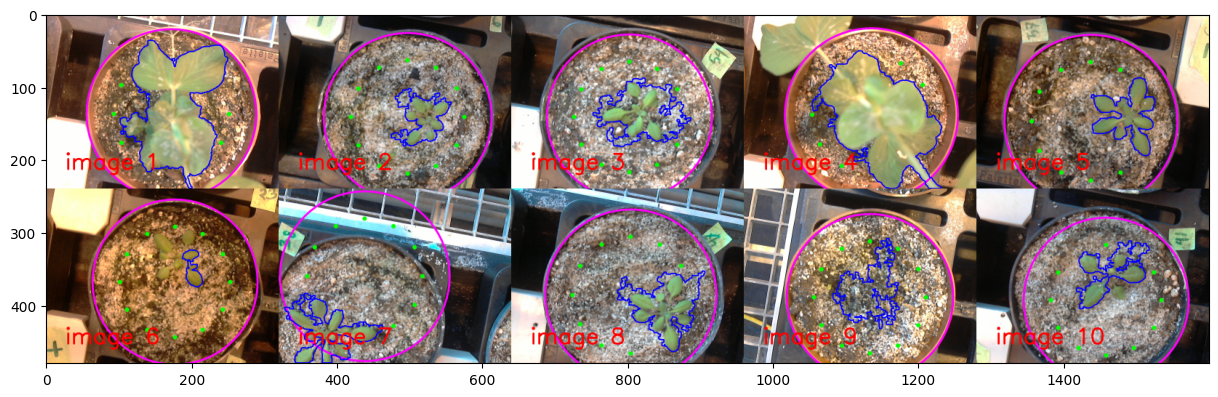

In [559]:
# Plot labels of each image
pcv.params.debug = 'None'

pcv.params.text_size = 4
pcv.params.text_thickness = 10
labeled_test_out_images = []


for i, test_img_out in enumerate(test_images_out):
    labeled=test_img_out.copy()
    labeled = cv.putText(img=labeled, text=test_image_names[i], org=(x,y),
                         fontFace=cv.FONT_HERSHEY_SIMPLEX,
                         fontScale=pcv.params.text_size, color=(0,0,255), thickness=pcv.params.text_thickness) 
    labeled_test_out_images.append(labeled)

plotting_img = np.vstack([np.hstack([labeled_test_out_images[0], labeled_test_out_images[1], labeled_test_out_images[2], labeled_test_out_images[3], labeled_test_out_images[4]]),
                          np.hstack([labeled_test_out_images[5], labeled_test_out_images[6], labeled_test_out_images[7], labeled_test_out_images[8], labeled_test_out_images[9]])])
plotting_img = pcv.transform.resize_factor(plotting_img, factors=(0.25,0.25))

#pcv.plot_image(plotting_img) this function will print the image on jupyter notebook zu small
plt.figure(figsize=(15,10))
plt.imshow(cv.cvtColor(plotting_img, cv.COLOR_BGR2RGB))
plt.show()

pcv.params.debug = 'plot'

### evaluation
First, I need to explain the legend of the results:
The magenta circle indicates the position of the flower pot, which is recognized by the program.
The program identifies the area of the plant's leaves as indicated by the blue contour.
The green dots indicate the optimal positions for watering the plant, avoiding pouring water on the leaves or too close to the edge of the flower pot.

As shown, the program produces correct results in 8 out of 10 cases.
In image 6, the program did not recognize all the leaves due to poor lighting conditions (warm light).
In Image 7, the program did not detect the flower top due to the interference of the metal grills on the top.